In [1]:
import zipfile
import json
import numpy as np
import pandas as pd
import os
import glob
# open zip files in folder
zf = zipfile.ZipFile('C:\Users\User\Documents\Jpython Notebook\DataChallenge\TrainingData.zip')

In [2]:
len(zf.namelist()) # the number of files

32

In [3]:
topics = 'activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,australiansecurityandcounterterrorism,bastilledaytruckattack,belgium,berlinchristmasmarketattack,bigdata,biometrics,bokoharam,bostonmarathonbombing,britisharmy,brusselsattacks,cameroon,carers,charliehebdoattack,chemicalweapons,clusterbombs,cobra,conflictanddevelopment,controversy,criminaljustice,cybercrime,cyberwar,darknet,dataprotection,debate,defence,deflation,drones,drugs,drugspolicy,drugstrade,earthquakes,ebola,economy,egypt,encryption,energy,espionage,ethics,europeanarrestwarrant,europeancourtofhumanrights,events,extradition,famine,farright,firefighters,forensicscience,france,francetrainattack,freedomofspeech,genevaconventions,germany,guncrime,hacking,hashtags,helicoptercrashes,humanitarianresponse,humanrights,humanrightsact,humantrafficking,immigration,india,indonesia,internallydisplacedpeople,internationalcourtofjustice,internationalcriminaljustice,internetsafety,iraq,isis,israel,jordan,jubilee,judiciary,july7,justiceandsecurity,kenya,knifecrime,lebanon,libya,localgovernment,logistics,london,londonriots,malaysia,mali,malware,metropolitanpolice,middleeastpeacetalks,migration,military,ministryofdefence,morocco,mrsa,mumbaiterrorattacks,munichshooting,naturaldisasters,nigeria,nuclearweapons,occupy,organisedcrime,orlandoterrorattack,osamabinladen,paris,parisattacks,peaceandreconciliation,philippines,piracy,planecrashes,police,protest,refugees,religion,retirementage,rio20earthsummit,royalairforce,royalnavy,russia,sanbernardinoshooting,saudiarabia,september11,slavery,somalia,southafrica,southchinasea,stopandsearch,surveillance,sydneysiege,syria,taliban,terrorism,thailand,torture,traincrashes,transport,tunisiaattack2015,turkey,turkeycoupattempt,ukcrime,uksecurity,uksupremecourt,undercoverpoliceandpolicing,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus'

In [4]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    """ clear text from stopwords and non_string symbols"""
    
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    stop_free = re.sub(r'\(.*?\)', "", stop_free)
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized.encode('ascii','ignore')

In [5]:
def to_vw_format(document, label=None, title =None):
    """ read text to vowpal_wabbit format """
    
    add1 = lambda x: ''.join(x) if np.all(x != None) else ''
    add2 = lambda x: ' '.join(x) if np.all(x != None) else 'bcg'
    doc = add1(title) +' |@default_class  '+ clean(document) +' |@labels_class  ' +add2(label) + '  \n'
    return  doc

- переведем текстовые zip json  данные в vowpal_wabbit format

In [6]:
import time
for ii,_ in enumerate(zf.namelist()):
    f_path = 'DataChallenge/train2/train_{}.vw'.format(str(ii))
    if not os.path.exists(f_path):
        if not os.path.exists('DataChallenge/val2/train_{}.vw'.format(str(ii))):
            break
print ii

31


In [7]:
%%time
validation_files = [30, 31] # files for validation
dic_file = open('DataChallenge/topicDictionary.txt','r')
dic_topics = dic_file.read().split('\n')

n_topics = len(dic_topics)

if os.path.exists('DataChallenge/df_tagerts2.csv'):
    
    df = pd.read_csv('DataChallenge/df_tagerts2.csv', index_col =0)
else:
    
    df = pd.DataFrame(index =dic_topics, dtype =np.int32)
    df.index.name = 'id'

start = time.time()
# open the zip file and convert one in vowpal_wabbit format
for i, name in enumerate(zf.namelist()):
    if i < ii-1:
        continue
    if len(df) != n_topics:
        print 'df lan error'
        break
    start_loop = time.time()
    f_path = 'DataChallenge/train2/train_{}.vw'.format(str(i))
    dir_ = os.path.dirname(f_path)
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    if i in validation_files:
        f_path = 'DataChallenge/val2/train_{}.vw'.format(str(i))
        dir_ = os.path.dirname(f_path)
        if not os.path.exists(dir_):
            os.makedirs(dir_)
    
    aticle = json.load( zf.open(name))
    
    with open( f_path, 'w') as vw_train:
        
        for key in sorted(aticle[u'TrainingData'].keys()):
            
            labels = np.array(aticle[u'TrainingData'][key][u'topics'])
            mask_lb = np.in1d(labels, dic_topics) # only topics from dictionary, we are going to consider
            
            if np.any(mask_lb):
                
                vw_train.write(to_vw_format(aticle[u'TrainingData'][key][u'bodyText'], labels[mask_lb],  key ))
                df[ key] = np.where(np.in1d(dic_topics, labels), 1, 0).astype(np.int32)
    
    print "loop --- %s seconds ---" % (time.time() - start_loop)
    print "whole ---%s seconds ---" % (time.time() - start)
    if len(df) == n_topics:
        df.to_csv('DataChallenge/df_tagerts2.csv')
        df.T.to_csv('DataChallenge/df_tagertsT.csv')
        print 'save %s DataChallenge/df_tagerts.csv  '%i, df.shape
    else:
        print 'lenth df error'
        break
    if (2*time.time() - start - start_loop)> 5700:
        open('DataChallenge/train2/train_{}.vw'.format(str(i+1)), 'w')
        break

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


loop --- 1023.88000011 seconds ---
whole ---1023.88000011 seconds ---
save 30 DataChallenge/df_tagerts.csv   (160, 226927)
loop --- 1021.73100019 seconds ---
whole ---2133.5630002 seconds ---
save 31 DataChallenge/df_tagerts.csv   (160, 236363)
Wall time: 41min 29s


- создадим бачи для обучения и валидации модели

In [60]:
import artm
import os
import glob
# convert to BatchVectorizer format the train files courps for  train
for f in glob.glob(os.path.join('DataChallenge/train2', '*.vw')):
     
    batch_vectorizer = artm.BatchVectorizer(data_path= f,
                                        data_format= "vowpal_wabbit",
                                        target_folder="DataChallenge/data_challenge_train", 
                                        batch_size=100)

In [2]:
# convert to BatchVectorizer format the validation files courps  for  test
for f in glob.glob(os.path.join('DataChallenge/val2', '*.vw')):
    batch_vectorizer = artm.BatchVectorizer(data_path= f,
                                        data_format= "vowpal_wabbit",
                                        target_folder="DataChallenge/data_challenge_validation", 
                                        batch_size=100)

- обучим модель на созданных батчах

In [1]:
import artm
dic_file = open('DataChallenge/topicDictionary.txt','r')
dic_topics = dic_file.read().split('\n')
batch_vectorizer = artm.BatchVectorizer(data_path="DataChallenge/data_challenge_train", data_format='batches')

In [61]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [3]:
import pandas as pd
df = pd.read_csv('DataChallenge/df_tagerts.csv', index_col =0)
df.head()

C:\Users\User\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Users\User\Anaconda2\lib\site-packages\IPython\core\formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
C:\Users\User\Anaconda2\lib\site-packages\IPython\core\formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
C:\Users\User\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
C:\Users\User\Anaconda2\lib\site-packages\IPython\core\formatters.py:672: DeprecationWarning: 

,1999a_TrainingData_00357,1999a_TrainingData_00358,1999a_TrainingData_00359,1999a_TrainingData_00360,1999a_TrainingData_00361,1999a_TrainingData_00368,1999a_TrainingData_00401,1999a_TrainingData_00402,1999a_TrainingData_00403,1999a_TrainingData_00404,...,2014b_TrainingData_52856,2014b_TrainingData_52861,2014b_TrainingData_52865,2014b_TrainingData_52866,2014b_TrainingData_52867,2014b_TrainingData_52872,2014b_TrainingData_52880,2014b_TrainingData_52887,2014b_TrainingData_52890,2014b_TrainingData_52891
id,,,,,,,,,,,,,,,,,,,,,
activism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
aid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
algerianhostagecrisis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alqaida,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df.shape

(160, 236363)

In [63]:
df.sum(axis =1)[df.sum(axis =1)!=0].min(), df.sum(axis =1)[df.sum(axis =1)!=0].max()

(3, 20516)

In [65]:
dictionary.filter(min_df=3, max_tf=236400, max_df_rate =0.99)

In [66]:
T = len(dic_topics)  # количество предметных тем
sbj_t = ["sbj_"+str(i) for i in range(T)]
bcg_t = ["bcg_"+str(i) for i in range(7)]
topic_names = sbj_t + bcg_t
# create artm model 
model_artm = artm.ARTM(num_topics =len(topic_names), topic_names=topic_names, 
                       class_ids={"@default_class":1, "@labels_class":10}, 
                       num_document_passes =10, reuse_theta=True, cache_theta=True, dictionary = dictionary)

In [67]:
model_artm.library_version

'0.8.3'

In [68]:
model_artm.initialize('dictionary')

- метрики качества обучения

In [69]:
model_artm.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score',
                                           class_id='@labels_class',
                                           topic_names =sbj_t))

model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens =15, 
                                          class_id="@default_class",
                                          topic_names =sbj_t))

model_artm.scores.add(artm.TopTokensScore(name="top_topics", num_tokens =4, 
                                          class_id="@labels_class", 
                                          topic_names =sbj_t))

model_artm.scores.add(artm.PerplexityScore(name ="Perflex_labels", 
                                           class_ids =['@labels_class'],
                                           topic_names =sbj_t,
                                           dictionary =dictionary))

model_artm.scores.add(artm.PerplexityScore(name ="Perflex_text", 
                                           class_ids =['@default_class'],
                                           topic_names =sbj_t,
                                           dictionary =dictionary))

#model_artm.scores.add(artm.ClassPrecisionScore(name ="class_precision"))

- первый проход сделаем по сглажеваем модель по общим темам, соберем самые употребляемые слова в общие темы 'bcg__t,  и разредим по предметным - sbj_ , сглаживаем классы по labels'

In [70]:
"""
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name ='Smooth_Phi', tau =1e5,
                                                            dictionary =dictionary, 
                                                            class_ids =["@default_class"],
                                                            topic_names =bcg_t ))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name ='Sparse_Phi', tau = -1.,
                                                          dictionary =dictionary, 
                                                           class_ids =["@default_class"],
                                                           topic_names =sbj_t ))
                                                           
model_artm.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='Label_Smooth', tau=10.0,
                                                                   dictionary =dictionary,
                                                                   topic_names=sbj_t))
"""
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_def', tau=1.0,
                                                           class_ids=['@default_class'],
                                                           topic_names =sbj_t))

model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_lab', tau=1.,
                                                           class_ids=['@labels_class'],
                                                           topic_names =sbj_t))

In [8]:
%%time
import numpy as np
import time
start = time.time()

taus_sparse = [np.power(10., e) for e in range(4)]
taus_decor = np.linspace(1., 0.1, len(taus_sparse))
for tau_s, tau_d in zip(taus_sparse, taus_decor):
    start_loop = time.time()
    print tau_s, tau_d
    model_artm.regularizers['Sparse_Phi'] = artm.SmoothSparsePhiRegularizer(name ='Sparse_Phi', 
                                                                           tau = -tau_s,
                                                           dictionary =dictionary, 
                                                           class_ids =["@default_class"],
                                                           topic_names =sbj_t )
    """
    model_artm.regularizers['decorrelator_phi_def'] =artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_def',
                                                                                     tau=tau_d,
                                                           class_ids=['@default_class'],
                                                           topic_names =sbj_t)
    
    model_artm.regularizers['decorrelator_phi_lab'] =artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_def',
                                                                                     tau=tau_d*0.5,
                                                           class_ids=['@labels_class'],
                                                           topic_names =sbj_t)
    """
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes =7)
    #model_artm.fit_online(batch_vectorizer=batch_vectorizer)
    
    print "whole -- %s seconds ---" % (time.time() - start)
    print "loop -- %s seconds ---" % (time.time() - start_loop)
    print "sparsity_phi_score"
    print model_artm.score_tracker["sparsity_phi_score"].value
    print 'Perflex_labels'
    print model_artm.score_tracker["Perflex_labels"].value
    print 'Perflex_text'
    print model_artm.score_tracker["Perflex_text"].value
    #print 'class_precision'
    #print model_artm.score_tracker["class_precision"].value
    print '-               -'
    if (2*time.time() - start - start_loop)> 5400:
        model_artm.save(filename='DataChallenge/saved_p_wt2', model_name='p_wt') 
        model_artm.save(filename='DataChallenge/saved_n_wt2', model_name='n_wt')
        dictionary.save(dictionary_path='DataChallenge/my_dictionary3')
        break
                                                   
    if model_artm.score_tracker["sparsity_phi_score"].last_value > 0.96: 
        break

1.0 1.0
whole -- 213.43200016 seconds ---
loop -- 213.43900013 seconds ---
sparsity_phi_score
[0.0, 0.0, 0.0021673387096774193, 0.13563508064516128, 0.35942540322580646, 0.486491935483871, 0.5721270161290323]
Perflex_labels
[112.26042850916389, 23.44944709369961, 11.46612194920603, 5.625326766313582, 4.253670684365791, 3.8264850589501074, 3.6216604772705487]
Perflex_text
[82273.73660986379, 5183.252266626416, 4039.07881724264, 2919.823368919967, 2457.3378124115193, 2254.5300825891586, 2147.2757037172173]
-               -
10.0 0.7
whole -- 419.984000206 seconds ---
loop -- 206.504999876 seconds ---
sparsity_phi_score
[0.0, 0.0, 0.0021673387096774193, 0.13563508064516128, 0.35942540322580646, 0.486491935483871, 0.5721270161290323, 0.6449092741935484, 0.7084173387096774, 0.7581149193548387, 0.797883064516129, 0.8272681451612903, 0.85, 0.8651713709677419]
Perflex_labels
[112.26042850916389, 23.44944709369961, 11.46612194920603, 5.625326766313582, 4.253670684365791, 3.8264850589501074, 3.6

In [71]:
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes =30)
    #model_artm.fit_online(batch_vectorizer=batch_vectorizer)
    
#print "whole -- %s seconds ---" % (time.time() - start)
#print "loop -- %s seconds ---" % (time.time() - start_loop)
print "sparsity_phi_score"
print model_artm.score_tracker["sparsity_phi_score"].value
print 'Perflex_labels'
print model_artm.score_tracker["Perflex_labels"].value
print 'Perflex_text'
print model_artm.score_tracker["Perflex_text"].value 

Wall time: 10min 43s
sparsity_phi_score
[0.0, 0.0, 0.001161504424778761, 0.12986725663716814, 0.33523230088495576, 0.4448008849557522, 0.5258849557522124, 0.6003318584070797, 0.6722898230088495, 0.7310287610619469, 0.7758296460176991, 0.8106194690265487, 0.8378871681415929, 0.8584070796460177, 0.8735066371681416, 0.8877765486725664, 0.897787610619469, 0.9059181415929204, 0.9144911504424779, 0.9201880530973451, 0.9257190265486726, 0.9300331858407079, 0.932853982300885, 0.9366703539823009, 0.9399889380530974, 0.9429203539823009, 0.9452433628318584, 0.9474004424778761, 0.9486725663716814, 0.9498893805309735]
Perflex_labels
[101.5798645178396, 22.745390298683596, 11.049299191168688, 5.289658198341394, 3.9653133109554433, 3.5570107149748242, 3.3664993057716317, 3.262959984788588, 3.2026091948677378, 3.1620111267922564, 3.1320456714688802, 3.109381954718851, 3.0927377073816693, 3.0800578493696613, 3.0695265432947956, 3.0610152965484225, 3.0547414053784165, 3.0494069682173244, 3.0442953123018

In [72]:
#model_artm.dispose()

In [73]:
print model_artm.score_tracker["sparsity_phi_score"].value

[0.0, 0.0, 0.001161504424778761, 0.12986725663716814, 0.33523230088495576, 0.4448008849557522, 0.5258849557522124, 0.6003318584070797, 0.6722898230088495, 0.7310287610619469, 0.7758296460176991, 0.8106194690265487, 0.8378871681415929, 0.8584070796460177, 0.8735066371681416, 0.8877765486725664, 0.897787610619469, 0.9059181415929204, 0.9144911504424779, 0.9201880530973451, 0.9257190265486726, 0.9300331858407079, 0.932853982300885, 0.9366703539823009, 0.9399889380530974, 0.9429203539823009, 0.9452433628318584, 0.9474004424778761, 0.9486725663716814, 0.9498893805309735]


In [74]:
theta = model_artm.get_theta()
print theta.shape
phi_c = model_artm.get_phi(class_ids=["@labels_class"] )
print phi_c.shape

(167, 10561)
(113, 167)


In [75]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

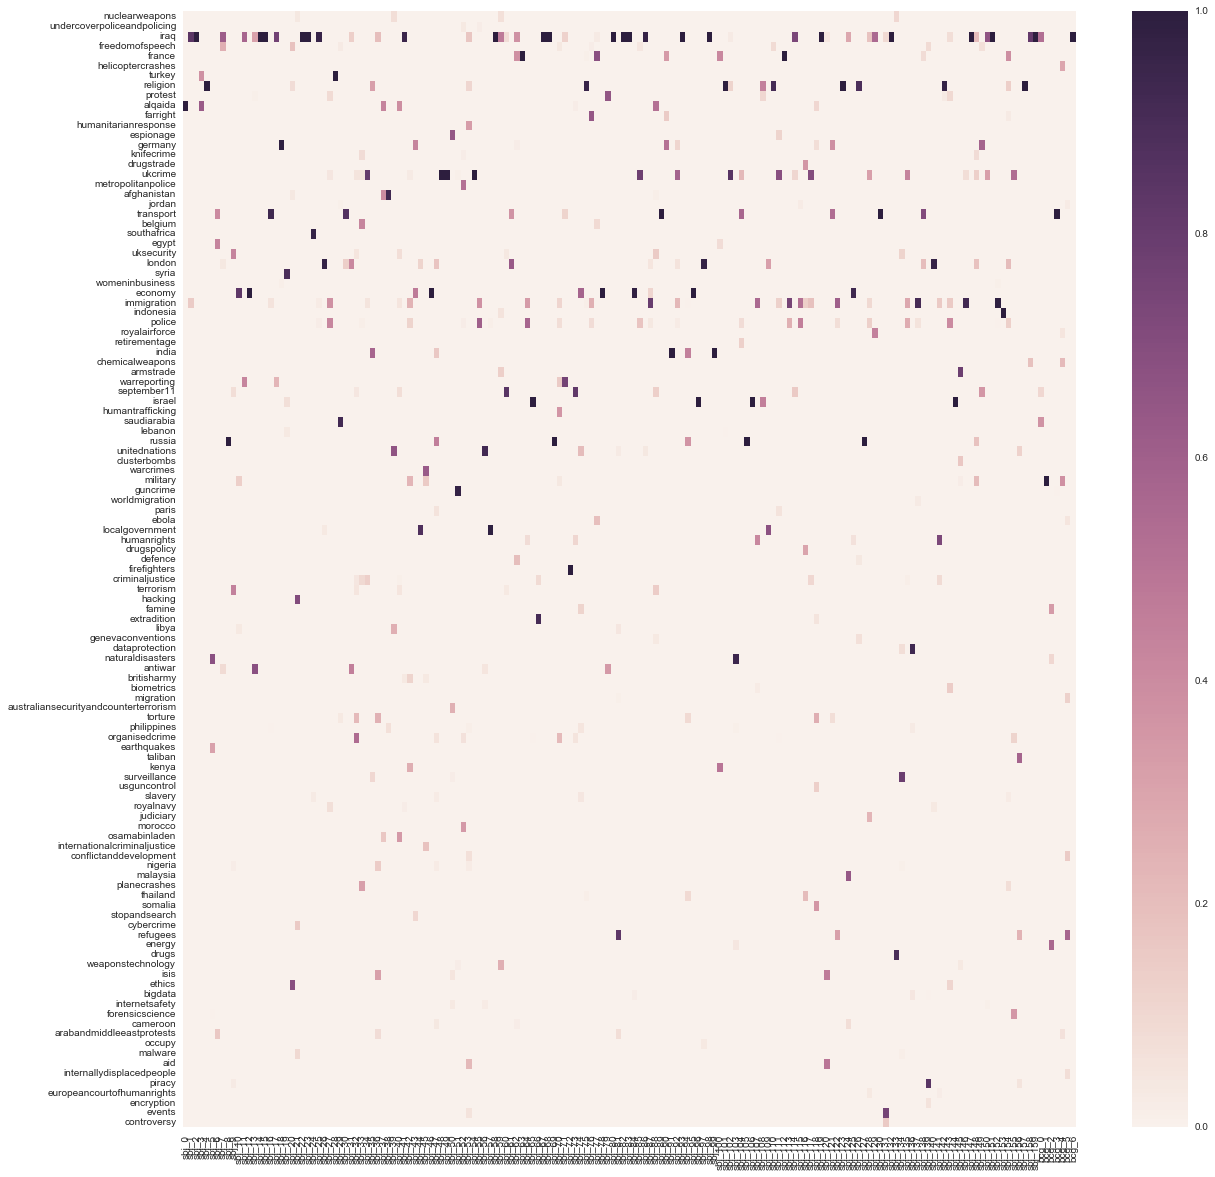

In [76]:
plt.figure(figsize=(20, 20))
seaborn.heatmap(phi_c)

In [13]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print 
    print "\t" + 'Words  : ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    
    for word in tokens[topic_name]:    
        print word,
    print
    authors = model_artm.score_tracker["top_topics"].last_tokens
    print "\t" + 'labels: ',
    for author in authors[topic_name]:
        print author,
    print

sbj_0: 
	Words  :  said attack u alqaida official arrested group terrorist killed last suspect two security yesterday suspected
	labels:  alqaida saudiarabia iraq espionage
sbj_1: 
	Words  :  politics new time people political may labour policy it could even war party world left
	labels:  iraq immigration unitednations germany
sbj_2: 
	Words  :  contract said iraq u company iraqi pentagon would plan military base firm work yesterday reconstruction
	labels:  iraq military germany
sbj_3: 
	Words  :  attack muslim terrorist british terrorism islamic said terror istanbul turkey bombing security country alqaida group
	labels:  turkey alqaida religion uksecurity
sbj_4: 
	Words  :  said club football clegg lib would party osborne motion liberal tory say like vote people
	labels:  freedomofspeech chemicalweapons economy religion
sbj_5: 
	Words  :  said people earthquake city island disaster mile area rescue bam water yesterday building survivor two
	labels:  naturaldisasters earthquakes weapon

KeyError: u'bcg_0'

In [ ]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 


- сохраним обученную модель

In [77]:
model_artm.save(filename='DataChallenge/saved_p_wt5', model_name='p_wt') 
model_artm.save(filename='DataChallenge/saved_n_wt5', model_name='n_wt')
dictionary.save(dictionary_path='DataChallenge/my_dictionary5')

- применим обученную  модель на валидационной выборке

In [43]:
import pandas as pd
import artm
import numpy as np
#dic = pd.read_csv('DataChallenge/topicDictionary.txt')
batch_vectorizer_val = artm.BatchVectorizer(data_path="DataChallenge/data_challenge_validation", data_format='batches')

In [2]:
dictionary = artm.Dictionary('dictionary')
dictionary.load(dictionary_path='DataChallenge/my_dictionary.dict')

In [3]:
T = len(dic)  # количество тем
sbj_t = ["sbj_"+str(i) for i in range(T)]
bcg_t = ["bcg_"+str(i) for i in range(7)]
topic_names = sbj_t + bcg_t
# create artm model 
model_artm = artm.ARTM(num_topics =len(topic_names), topic_names=topic_names, 
                       class_ids={"@default_class":1, "@labels_class":10}, 
                       num_document_passes=10, reuse_theta=True, cache_theta=True, dictionary = dictionary)

In [9]:
model_artm.load(filename='DataChallenge/saved_p_wt', model_name='p_wt')
model_artm.load(filename='DataChallenge/saved_n_wt', model_name='n_wt')

In [44]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta_test = model_artm.transform(batch_vectorizer=batch_vectorizer_val)

In [45]:
p_cd_test = model_artm.transform(batch_vectorizer=batch_vectorizer_val,
                                 predict_class_id='@labels_class')

In [48]:
p_cd_test.to_csv('DataChallenge/DataChallenge_p_cd_test.csv')

- запишем таблицу правильных ответов

In [18]:
df =pd.read_csv('DataChallenge/df_tagerts2.csv', index_col=0 )

In [46]:
df_test = df[p_cd_test.columns]
df_test.head(10)

,2014b_TrainingData_52789,2014b_TrainingData_52790,2014b_TrainingData_52791,2014b_TrainingData_52792,2014b_TrainingData_52793,2014b_TrainingData_52794,2014b_TrainingData_52795,2014b_TrainingData_52796,2014b_TrainingData_52797,2014b_TrainingData_52798,...,2014b_TrainingData_29623,2014b_TrainingData_29626,2014b_TrainingData_29635,2014b_TrainingData_29640,2014b_TrainingData_29641,2014b_TrainingData_29643,2014b_TrainingData_29644,2014b_TrainingData_29652,2014b_TrainingData_29658,2014b_TrainingData_29659
id,,,,,,,,,,,,,,,,,,,,,
activism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
aid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
algerianhostagecrisis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alqaida,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alshabaab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
antiwar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arabandmiddleeastprotests,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
armstrade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
dic_topics

['activism',
 'afghanistan',
 'aid',
 'algerianhostagecrisis',
 'alqaida',
 'alshabaab',
 'antiwar',
 'arabandmiddleeastprotests',
 'armstrade',
 'australianguncontrol',
 'australiansecurityandcounterterrorism',
 'bastilledaytruckattack',
 'belgium',
 'berlinchristmasmarketattack',
 'bigdata',
 'biometrics',
 'bokoharam',
 'bostonmarathonbombing',
 'britisharmy',
 'brusselsattacks',
 'cameroon',
 'carers',
 'charliehebdoattack',
 'chemicalweapons',
 'clusterbombs',
 'cobra',
 'conflictanddevelopment',
 'controversy',
 'criminaljustice',
 'cybercrime',
 'cyberwar',
 'darknet',
 'dataprotection',
 'debate',
 'defence',
 'deflation',
 'drones',
 'drugs',
 'drugspolicy',
 'drugstrade',
 'earthquakes',
 'ebola',
 'economy',
 'egypt',
 'encryption',
 'energy',
 'espionage',
 'ethics',
 'europeanarrestwarrant',
 'europeancourtofhumanrights',
 'events',
 'extradition',
 'famine',
 'farright',
 'firefighters',
 'forensicscience',
 'france',
 'francetrainattack',
 'freedomofspeech',
 'genevaconv

In [48]:
p_cd_T = p_cd_test.T
df_test = df_test.T
for col in np.setdiff1d(df_test.columns, p_cd_T.columns):
    p_cd_T[col] = 0
p_cd_T =p_cd_T[df_test.columns]

In [49]:
from sklearn.metrics import f1_score
best_threshold = 0.1
for threshold in np.linspace(best_threshold, 0.15, num=40):
    #predict = (p_cd_T[df_test.columns].values > threshold).astype(int)
    predict = (p_cd_T.values > threshold).astype(int)
    f1_sc = f1_score(df_test.values, predict, average='micro') 
    print 'threshold {}  score_f1  {}'.format(threshold, f1_sc)
    if threshold ==0.1:
        best_score = f1_sc
    if f1_sc > best_score:
        best_threshold = threshold
        best_score = f1_sc
print "best_threshold  {}  best score {}".format(best_threshold, best_score)

threshold 0.1  score_f1  0.43975504361
threshold 0.101282051282  score_f1  0.440932226092
threshold 0.102564102564  score_f1  0.442154237334
threshold 0.103846153846  score_f1  0.442903172956
threshold 0.105128205128  score_f1  0.443630353946
threshold 0.10641025641  score_f1  0.443604844983
threshold 0.107692307692  score_f1  0.443864522827
threshold 0.108974358974  score_f1  0.445149951811
threshold 0.110256410256  score_f1  0.444533348574
threshold 0.111538461538  score_f1  0.4454689526
threshold 0.112820512821  score_f1  0.445890968267
threshold 0.114102564103  score_f1  0.4456550391
threshold 0.115384615385  score_f1  0.445664040601
threshold 0.116666666667  score_f1  0.445892081623
threshold 0.117948717949  score_f1  0.446410894802
threshold 0.119230769231  score_f1  0.447265034754
threshold 0.120512820513  score_f1  0.447378829829
threshold 0.121794871795  score_f1  0.447274954072
threshold 0.123076923077  score_f1  0.446810480511
threshold 0.124358974359  score_f1  0.4466206553

In [24]:
Pred_max = p_cd_T.copy()

In [25]:
Pred_max.head()

,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
2014b_TrainingData_52789,0,0.000012,0.001551,0,0.000233,1.573431e-07,0.000030,0.000279,0.000554,0,...,0.009230,0.000015,0,0.000032,0.000553,0.000252,1.568253e-08,0.000003,0.007558,0
2014b_TrainingData_52790,0,0.010820,0.011114,0,0.003928,4.024190e-06,0.005083,0.011583,0.001192,0,...,0.048702,0.000175,0,0.002241,0.002012,0.000434,8.076208e-07,0.000087,0.000136,0
2014b_TrainingData_52791,0,0.004499,0.026723,0,0.016466,1.414251e-06,0.000727,0.010701,0.001278,0,...,0.037993,0.000030,0,0.000159,0.000441,0.000185,2.993492e-07,0.000042,0.000276,0
2014b_TrainingData_52792,0,0.000152,0.017814,0,0.008001,3.491972e-04,0.006540,0.001754,0.000187,0,...,0.005620,0.000383,0,0.000773,0.004806,0.001096,4.028477e-05,0.000852,0.002355,0
2014b_TrainingData_52793,0,0.001495,0.001103,0,0.000685,1.105786e-05,0.016657,0.006468,0.000079,0,...,0.007187,0.000132,0,0.000018,0.000225,0.000253,2.479135e-06,0.000105,0.000015,0


In [26]:
p_cd_T.idxmax(axis =1).head()

2014b_TrainingData_52789    immigration
2014b_TrainingData_52790       refugees
2014b_TrainingData_52791       refugees
2014b_TrainingData_52792        ukcrime
2014b_TrainingData_52793    immigration
dtype: object

In [27]:
p_cd_T.idxmax(axis =1)[p_cd_T.idxmax(axis =1).index[0]], p_cd_T.idxmax(axis =1).index[0]

(u'immigration', u'2014b_TrainingData_52789')

In [28]:
Pred_max.ix[u'2014b_TrainingData_52789', u'immigration']

0.30620858

In [29]:
p_cd_max = p_cd_T.idxmax(axis =1)
for ind in p_cd_max.index:
    
    Pred_max.ix[ind, p_cd_max[ind]] = 1.

In [30]:
from sklearn.metrics import f1_score
best_threshold = 0.1
for threshold in np.linspace(best_threshold, 0.14, num=40):
    #predict = (p_cd_T[df_test.columns].values > threshold).astype(int)
    predict = (Pred_max.values > threshold).astype(int)
    f1_sc = f1_score(df_test.values, predict, average='micro') 
    print 'threshold {}  score_f1  {}'.format(threshold, f1_sc)
    if threshold ==0.1:
        best_score = f1_sc
    if f1_sc > best_score:
        best_threshold = threshold
        best_score = f1_sc
print "best_threshold  {}  best score {}".format(best_threshold, best_score)

threshold 0.1  score_f1  0.433040629448
threshold 0.101025641026  score_f1  0.433455763206
threshold 0.102051282051  score_f1  0.433867898886
threshold 0.103076923077  score_f1  0.433792952506
threshold 0.104102564103  score_f1  0.434301140433
threshold 0.105128205128  score_f1  0.434268587128
threshold 0.106153846154  score_f1  0.434979458372
threshold 0.107179487179  score_f1  0.435112999916
threshold 0.108205128205  score_f1  0.435493021673
threshold 0.109230769231  score_f1  0.436135293278
threshold 0.110256410256  score_f1  0.436260297959
threshold 0.111282051282  score_f1  0.436033745522
threshold 0.112307692308  score_f1  0.435935455735
threshold 0.113333333333  score_f1  0.435715956949
threshold 0.114358974359  score_f1  0.435812996178
threshold 0.115384615385  score_f1  0.435651762479
threshold 0.11641025641  score_f1  0.436152817006
threshold 0.117435897436  score_f1  0.43591123871
threshold 0.118461538462  score_f1  0.435841905793
threshold 0.119487179487  score_f1  0.435850

In [35]:
import zipfile
import json
import numpy as np
import pandas as pd
import os
import glob
# open zip files in folder
zf = zipfile.ZipFile('C:\Users\User\Documents\Jpython Notebook\DataChallenge\TestData.zip')

In [36]:
len(zf.namelist()) # the number of files

1

In [37]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    """ clear text from stopwords and non_string symbols"""
    
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    stop_free = re.sub(r'\(.*?\)', "", stop_free)
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized.encode('ascii','ignore')

In [64]:
def to_vw_format(document, label=None, title =None):
    """ read text to vowpal_wabbit format """
    
    add1 = lambda x: ''.join(x) if np.all(x != None) else ''
    add2 = lambda x: ' '.join(x) if np.all(x != None) else ''
    doc = add1(title) +' |@default_class  '+ clean(document) +' |@labels_class  ' +add2(label) + '  \n'
    return  doc

In [38]:
%%time
f_path = 'DataChallenge/test/test.vw'
dir_ = os.path.dirname(f_path)
if not os.path.exists(dir_):
    os.makedirs(dir_)
# open the zip file and convert one in vowpal_wabbit format
for name in zf.namelist():
    
    aticle = json.load( zf.open(name))
"""
    with open( f_path, 'w') as vw_train:

        for key in sorted(aticle[u'TestData'].keys()):

            labels = np.array(aticle[u'TestData'][key][u'topics'])
            vw_train.write(to_vw_format(aticle[u'TestData'][key][u'bodyText'], labels ,  key ))"""

Wall time: 1.13 s


In [59]:
import pandas as pd
import artm
import numpy as np
# convert to BatchVectorizer format the validation files courps  for  test
batch_test = artm.BatchVectorizer(data_path= 'DataChallenge/test/test.vw',
                                        data_format= "vowpal_wabbit",
                                        target_folder="DataChallenge/data_challenge_test", 
                                        batch_size=100)

In [68]:
import pandas as pd
import artm
import numpy as np
dic = pd.read_csv('DataChallenge/topicDictionary.txt')


In [69]:
dictionary = artm.Dictionary('dictionary')
dictionary.load(dictionary_path='DataChallenge/my_dictionary.dict')

In [70]:
T = len(dic)  # количество тем
sbj_t = ["sbj_"+str(i) for i in range(T)]
bcg_t = ["bcg_"+str(i) for i in range(7)]
topic_names = sbj_t + bcg_t
# create artm model 
model_artm = artm.ARTM(num_topics =len(topic_names), topic_names=topic_names, 
                       class_ids={"@default_class":1, "@labels_class":10}, 
                       num_document_passes=10, reuse_theta=True, cache_theta=True, dictionary = dictionary)

In [71]:
model_artm.load(filename='DataChallenge/saved_p_wt', model_name='p_wt')
model_artm.load(filename='DataChallenge/saved_n_wt', model_name='n_wt')

In [78]:
batch_test = artm.BatchVectorizer(data_path="DataChallenge/data_challenge_test", data_format='batches')
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta_test = model_artm.transform(batch_vectorizer=batch_test)

In [79]:
p_cd_test = model_artm.transform(batch_vectorizer=batch_test,
                                 predict_class_id='@labels_class')

In [80]:
p_cd_test[sorted(aticle[u'TestData'].keys())]

,TestData_00001,TestData_00002,TestData_00003,TestData_00004,TestData_00005,TestData_00006,TestData_00007,TestData_00008,TestData_00009,TestData_00010,...,TestData_07572,TestData_07573,TestData_07574,TestData_07575,TestData_07576,TestData_07577,TestData_07578,TestData_07579,TestData_07580,TestData_07581
nuclearweapons,0.002484,0.002155,9.979358e-03,4.674050e-04,0.000163,0.002682,0.000936,0.000521,1.461485e-02,0.011272,...,0.000207,0.000582,0.001462,1.814891e-05,6.772178e-03,5.205612e-03,0.007557,0.000062,0.005108,0.005703
undercoverpoliceandpolicing,0.000016,0.000074,9.462014e-04,5.431743e-07,0.000390,0.000052,0.000431,0.000009,8.731898e-04,0.000667,...,0.000004,0.000548,0.000046,9.769903e-06,4.606581e-05,1.928439e-03,0.000051,0.000023,0.000005,0.000006
iraq,0.063587,0.124338,5.113267e-02,1.086780e-01,0.140378,0.258446,0.215289,0.195659,1.761089e-01,0.132098,...,0.214252,0.145319,0.086047,4.506153e-02,2.111875e-01,1.680313e-01,0.143003,0.024274,0.278757,0.159449
freedomofspeech,0.003184,0.000486,9.807614e-03,1.841638e-03,0.004009,0.000979,0.007269,0.000687,3.567190e-03,0.006657,...,0.005025,0.000694,0.008432,2.709940e-03,1.138831e-03,4.160934e-03,0.000399,0.001208,0.000733,0.000773
france,0.002622,0.032269,1.045429e-03,8.087085e-03,0.102933,0.028009,0.038374,0.020153,7.192186e-04,0.003517,...,0.033538,0.034239,0.012478,1.154310e-01,3.068570e-02,2.632732e-03,0.012354,0.013330,0.003616,0.008137
helicoptercrashes,0.001141,0.000010,3.831059e-05,2.793840e-02,0.000441,0.000084,0.000769,0.001494,2.560231e-06,0.000317,...,0.011751,0.000030,0.000538,2.496284e-04,4.324271e-05,1.126721e-03,0.000106,0.000971,0.000034,0.000016
turkey,0.003804,0.004637,8.389038e-04,2.991501e-04,0.035207,0.057465,0.028563,0.000402,2.133637e-03,0.005796,...,0.001332,0.000442,0.000264,1.352680e-02,5.095298e-03,5.133362e-03,0.081134,0.016071,0.109129,0.064237
religion,0.020304,0.001331,5.636233e-03,5.489422e-02,0.081655,0.016236,0.087702,0.004863,1.936352e-02,0.008908,...,0.073744,0.010896,0.073546,2.708648e-02,3.460988e-02,8.650656e-03,0.002957,0.007109,0.003080,0.015622
protest,0.001519,0.000665,3.507918e-03,2.975595e-03,0.013600,0.000924,0.032918,0.001789,2.349427e-04,0.001351,...,0.015992,0.000314,0.005983,3.598471e-03,6.256582e-03,1.221759e-02,0.001776,0.000304,0.000421,0.001708
alqaida,0.009622,0.007559,1.757208e-01,3.798725e-04,0.004815,0.053898,0.061305,0.049194,1.354980e-02,0.056788,...,0.002260,0.001740,0.000908,1.182545e-01,1.003946e-02,2.023388e-02,0.013099,0.014102,0.003374,0.020889


In [81]:
must = 'id,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,australiansecurityandcounterterrorism,bastilledaytruckattack,belgium,berlinchristmasmarketattack,bigdata,biometrics,bokoharam,bostonmarathonbombing,britisharmy,brusselsattacks,cameroon,carers,charliehebdoattack,chemicalweapons,clusterbombs,cobra,conflictanddevelopment,controversy,criminaljustice,cybercrime,cyberwar,darknet,dataprotection,debate,defence,deflation,drones,drugs,drugspolicy,drugstrade,earthquakes,ebola,economy,egypt,encryption,energy,espionage,ethics,europeanarrestwarrant,europeancourtofhumanrights,events,extradition,famine,farright,firefighters,forensicscience,france,francetrainattack,freedomofspeech,genevaconventions,germany,guncrime,hacking,hashtags,helicoptercrashes,humanitarianresponse,humanrights,humanrightsact,humantrafficking,immigration,india,indonesia,internallydisplacedpeople,internationalcourtofjustice,internationalcriminaljustice,internetsafety,iraq,isis,israel,jordan,jubilee,judiciary,july7,justiceandsecurity,kenya,knifecrime,lebanon,libya,localgovernment,logistics,london,londonriots,malaysia,mali,malware,metropolitanpolice,middleeastpeacetalks,migration,military,ministryofdefence,morocco,mrsa,mumbaiterrorattacks,munichshooting,naturaldisasters,nigeria,nuclearweapons,occupy,organisedcrime,orlandoterrorattack,osamabinladen,paris,parisattacks,peaceandreconciliation,philippines,piracy,planecrashes,police,protest,refugees,religion,retirementage,rio20earthsummit,royalairforce,royalnavy,russia,sanbernardinoshooting,saudiarabia,september11,slavery,somalia,southafrica,southchinasea,stopandsearch,surveillance,sydneysiege,syria,taliban,terrorism,thailand,torture,traincrashes,transport,tunisiaattack2015,turkey,turkeycoupattempt,ukcrime,uksecurity,uksupremecourt,undercoverpoliceandpolicing,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus'

In [82]:
p_cd_T = p_cd_test[sorted(aticle[u'TestData'].keys())].T
for col in np.setdiff1d(must.split(',')[1:], p_cd_T.columns):
    p_cd_T[col] = 0
p_cd_T =p_cd_T[must.split(',')[1:]]

In [87]:
p_cd_max = p_cd_T.idxmax(axis =1)
for ind in p_cd_max.index:
    
    p_cd_T.ix[ind, p_cd_max[ind]] = 1.

In [90]:
test_sub =(p_cd_T > 0.09).astype(int)
test_sub.head()

,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
id,,,,,,,,,,,,,,,,,,,,,
TestData_00001,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TestData_00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TestData_00003,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TestData_00004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TestData_00005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
test_sub.index.name = 'id'
test_sub.head()

,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
id,,,,,,,,,,,,,,,,,,,,,
TestData_00001,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TestData_00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TestData_00003,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TestData_00004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TestData_00005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
test_sub.to_csv('DataChallenge/DataChallenge_test.csv')